In [1]:
from scipy.io import loadmat
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import KMeans

# 2. Implementing EM for MNIST dataset, with PCA for dimensionality reduction.

## 2a
Select from data one raw image of “2” and “6” and visualize them, respectively.

In [2]:
images = loadmat('data/data.mat')['data']
labels = loadmat('data/label.mat')['trueLabel']
example2 = images[:, 0].reshape(28, 28).T
example6 =  images[:,-1].reshape(28, 28).T

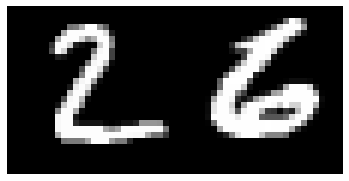

In [3]:
fig = plt.figure()
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0)
grid[0].imshow(example2, cmap='gray')
grid[0].axis('off')
grid[0].set_xticks([])
grid[0].set_yticks([])
grid[1].imshow(example6, cmap='gray')
grid[1].axis('off')
grid[1].set_xticks([])
grid[1].set_yticks([])
plt.savefig('data/HW3_Q2a.png') 

## 2c

Implement EM algorithm yourself. Use the following initialization

• initialization for mean: random Gaussian vector with zero mean

• initialization for covariance:

generate two Gaussian random matrix of size n-by-
n: S 1 and S 2 , and initialize the covariance matrix for the two components are
Σ 1 = S 1 S 1 T + I n , and Σ 2 = S 2 S 2 T + I n , where I n is an identity matrix of size
n-by-n.

Plot the log-likelihood function versus the number of iterations to show your algorithm
is converging.

In [4]:
K = 2  # number of clusters
d = 5  # reduced dimension
seed = 3836
np.random.seed(seed)
images = images.T
print(f"Images shape: {images.shape}")
m, n = images.shape
cimages = images - np.mean(images, axis=0)
C = np.dot(cimages.T, cimages)/m

U, s, V = np.linalg.svd(C)
U = U[:, :d]

pimages = np.dot(images, U)
print(f"PCA images shape: {pimages.shape}")

Images shape: (1990, 784)
PCA images shape: (1990, 5)


In [5]:
def gen_random_input(clus, dim):

    pi = np.random.rand(clus)
    pi = pi/np.sum(pi)
    mu = np.random.rand(clus,dim)
    sigma = []
    for ii in range(clus):
        # to ensure the covariance psd
        # np.random.seed(seed)
        dummy = np.random.randn(dim, dim)
        sigma.append(dummy@dummy.T)
    sigma = np.array(sigma) + np.eye(dim)
    return pi, mu, sigma

In [6]:
pi, mu, sigma = gen_random_input(2, 5)
mu_old = mu.copy()
tau = np.full((m, K), fill_value=0.)
print(f"U shape: {U.shape}")
print(f"pi shape: {pi.shape}")
print(f"mu shape: {mu.shape}")
print(f"sigma shape: {sigma.shape}")
print(f"tau shape: {tau.shape}")

U shape: (784, 5)
pi shape: (2,)
mu shape: (2, 5)
sigma shape: (2, 5, 5)
tau shape: (1990, 2)


In [7]:
maxIter= 200
tol = 1e-3

ll = []
for ii in range(maxIter):

    # E-step    
    for kk in range(K):
        tau[:, kk] = pi[kk] * mvn.pdf(pimages, mu[kk], sigma[kk])
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m,1)    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
    ll.append(np.sum(np.log(sum_tau)))
    
    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = pimages.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        
        # update cov matrix
        dummy = pimages - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
        
    # print('-----iteration---',ii)    
    if np.linalg.norm(mu-mu_old) == 0: #< tol:
        # print('training coverged')
        break
    mu_old = mu.copy()
    if ii==maxIter-1:
        # print('max iteration reached')
        break

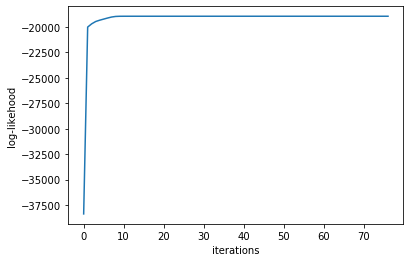

In [8]:
plt.plot(ll)
plt.xlabel('iterations')
plt.ylabel('log-likehood')
plt.savefig('data/HW3_Q2b.png')

## 2d
Report, the fitted GMM model when EM has terminated in youralgorithms as follows.  Make sure to report the weights for each component, and themean  of  each  component  (you  can  reformat  the  vector  to  make  them  into  28-by-28matrices and show images).  Ideally, you should be able to see these means correspondsto “average” images.  Report the two 784-by-784 covariance matrices by visualize their intensities.

In [9]:
print(f"component weights: {pi}")
print(f"component means: {mu}")

component weights: [0.49313429 0.50686571]
component means: [[-1.20409102 -4.41784437 -0.27699913  4.96306035  0.87272481]
 [ 2.89673174 -3.27123181 -0.05445827  4.93065369  0.49325342]]


In [10]:
t = np.matrix(mu[:,:d]) * np.diag(s[:d]) * np.matrix(V[:d, :]) + np.mean(images, axis=0)

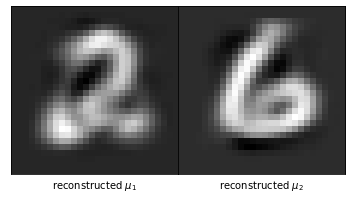

In [11]:
fig = plt.figure()
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0)
for i in range(t.shape[0]):
    grid[i].imshow(t[i].reshape(28, 28).T, cmap='gray')
    grid[i].set_xticks([])
    grid[i].set_yticks([])
    grid[i].set_xlabel(f"reconstructed $\mu_{i+1}$")
plt.savefig('data/HW3_Q2c_mean.png') 

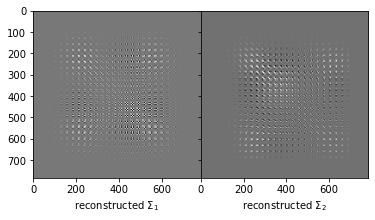

In [12]:
fig = plt.figure()
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0)
for i in range(K):
    cov = (np.matrix(U) * np.diag(s[:d])) * sigma[i] *  (np.sqrt(np.diag(s[:d])) * np.matrix(U.T))
    grid[i].imshow(cov, cmap='gray')
    grid[i].set_xlabel(rf"reconstructed $\Sigma_{i+1}$")
plt.savefig('data/HW3_Q2c_cov.png') 

## 2e
Use  the τik to  infer  the  labels  of  the  images,  and  compare  with  the  truelabels.  Report the mis-classification rate for digits “2” and “6” respectively.  Compare with GMM using PCA that you have implemented in Question 2.  Which one achieves better performance?

In [13]:
def ifelse(cond, a, b):
    if cond:
        return a
    else:
        return b

predictions = np.array([ifelse(t[0] >= t[1], 0, 1) for t in tau])
actuals = [ifelse(a==2, 0, 1) for a in labels.flatten().tolist()]
diffs = np.abs(np.array(predictions) - np.array(actuals))
misclassify = np.sum(diffs)/diffs.shape[0]
idx2 = np.where(labels == 2)[1]
idx6 = np.where(labels == 6)[1]
miss2 = sum(predictions[idx2])/predictions[idx2].shape[0]
miss6 = 1 - sum(predictions[idx6])/predictions[idx6].shape[0]
print(f"total misclassification rate: {misclassify}")
print(f"2 misclassification rate: {miss2}")
print(f"6 misclassification rate: {miss6}")

total misclassification rate: 0.033668341708542715
2 misclassification rate: 0.05813953488372093
6 misclassification rate: 0.007306889352818424


In [14]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(pimages)
km_predictions = kmeans.labels_
km_diffs =  np.abs(np.array(km_predictions) - np.array(actuals))
km_misclassify = np.sum(km_diffs)/km_diffs.shape[0]

km_miss2 = sum(km_predictions[idx2])/km_predictions[idx2].shape[0]
km_miss6 = 1 - sum(km_predictions[idx6])/km_predictions[idx6].shape[0]
print(f"KMeans total misclassification rate: {km_misclassify}")
print(f"KMeans 2 misclassification rate: {km_miss2}")
print(f"KMEans 6 misclassification rate: {km_miss6}")

KMeans total misclassification rate: 0.06080402010050251
KMeans 2 misclassification rate: 0.07364341085271318
KMEans 6 misclassification rate: 0.04697286012526092
